# Inference with Mask2Former

[Mask2Former](https://huggingface.co/docs/transformers/main/en/model_doc/mask2former) is a very nice new model from Meta AI, capable of solving any type of image segmentation (whether it's instance, semantic or panoptic segmentation) using the same architecture. The model improves upon [DETR](https://huggingface.co/docs/transformers/model_doc/detr) and [MaskFormer](https://huggingface.co/docs/transformers/model_doc/maskformer) by incorporating masked attention in its Transformer decoder.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/mask2former_architecture.jpg" alt="drawing" width="500"/>

In this notebook, we'll illustrate inference with this model (i.e. making predictions on a new image) for panoptic, semantic and instance segmentation.

## Set-up environment

First, we install 🤗 Transformers. We install from Github here since the Mask2Former model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00


## Define model

Next, we instantiate a Mask2Former model from the [hub](https://huggingface.co/models?other=mask2former), along with its image processor.

In [18]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-mapillary-vistas-semantic")

## Load image

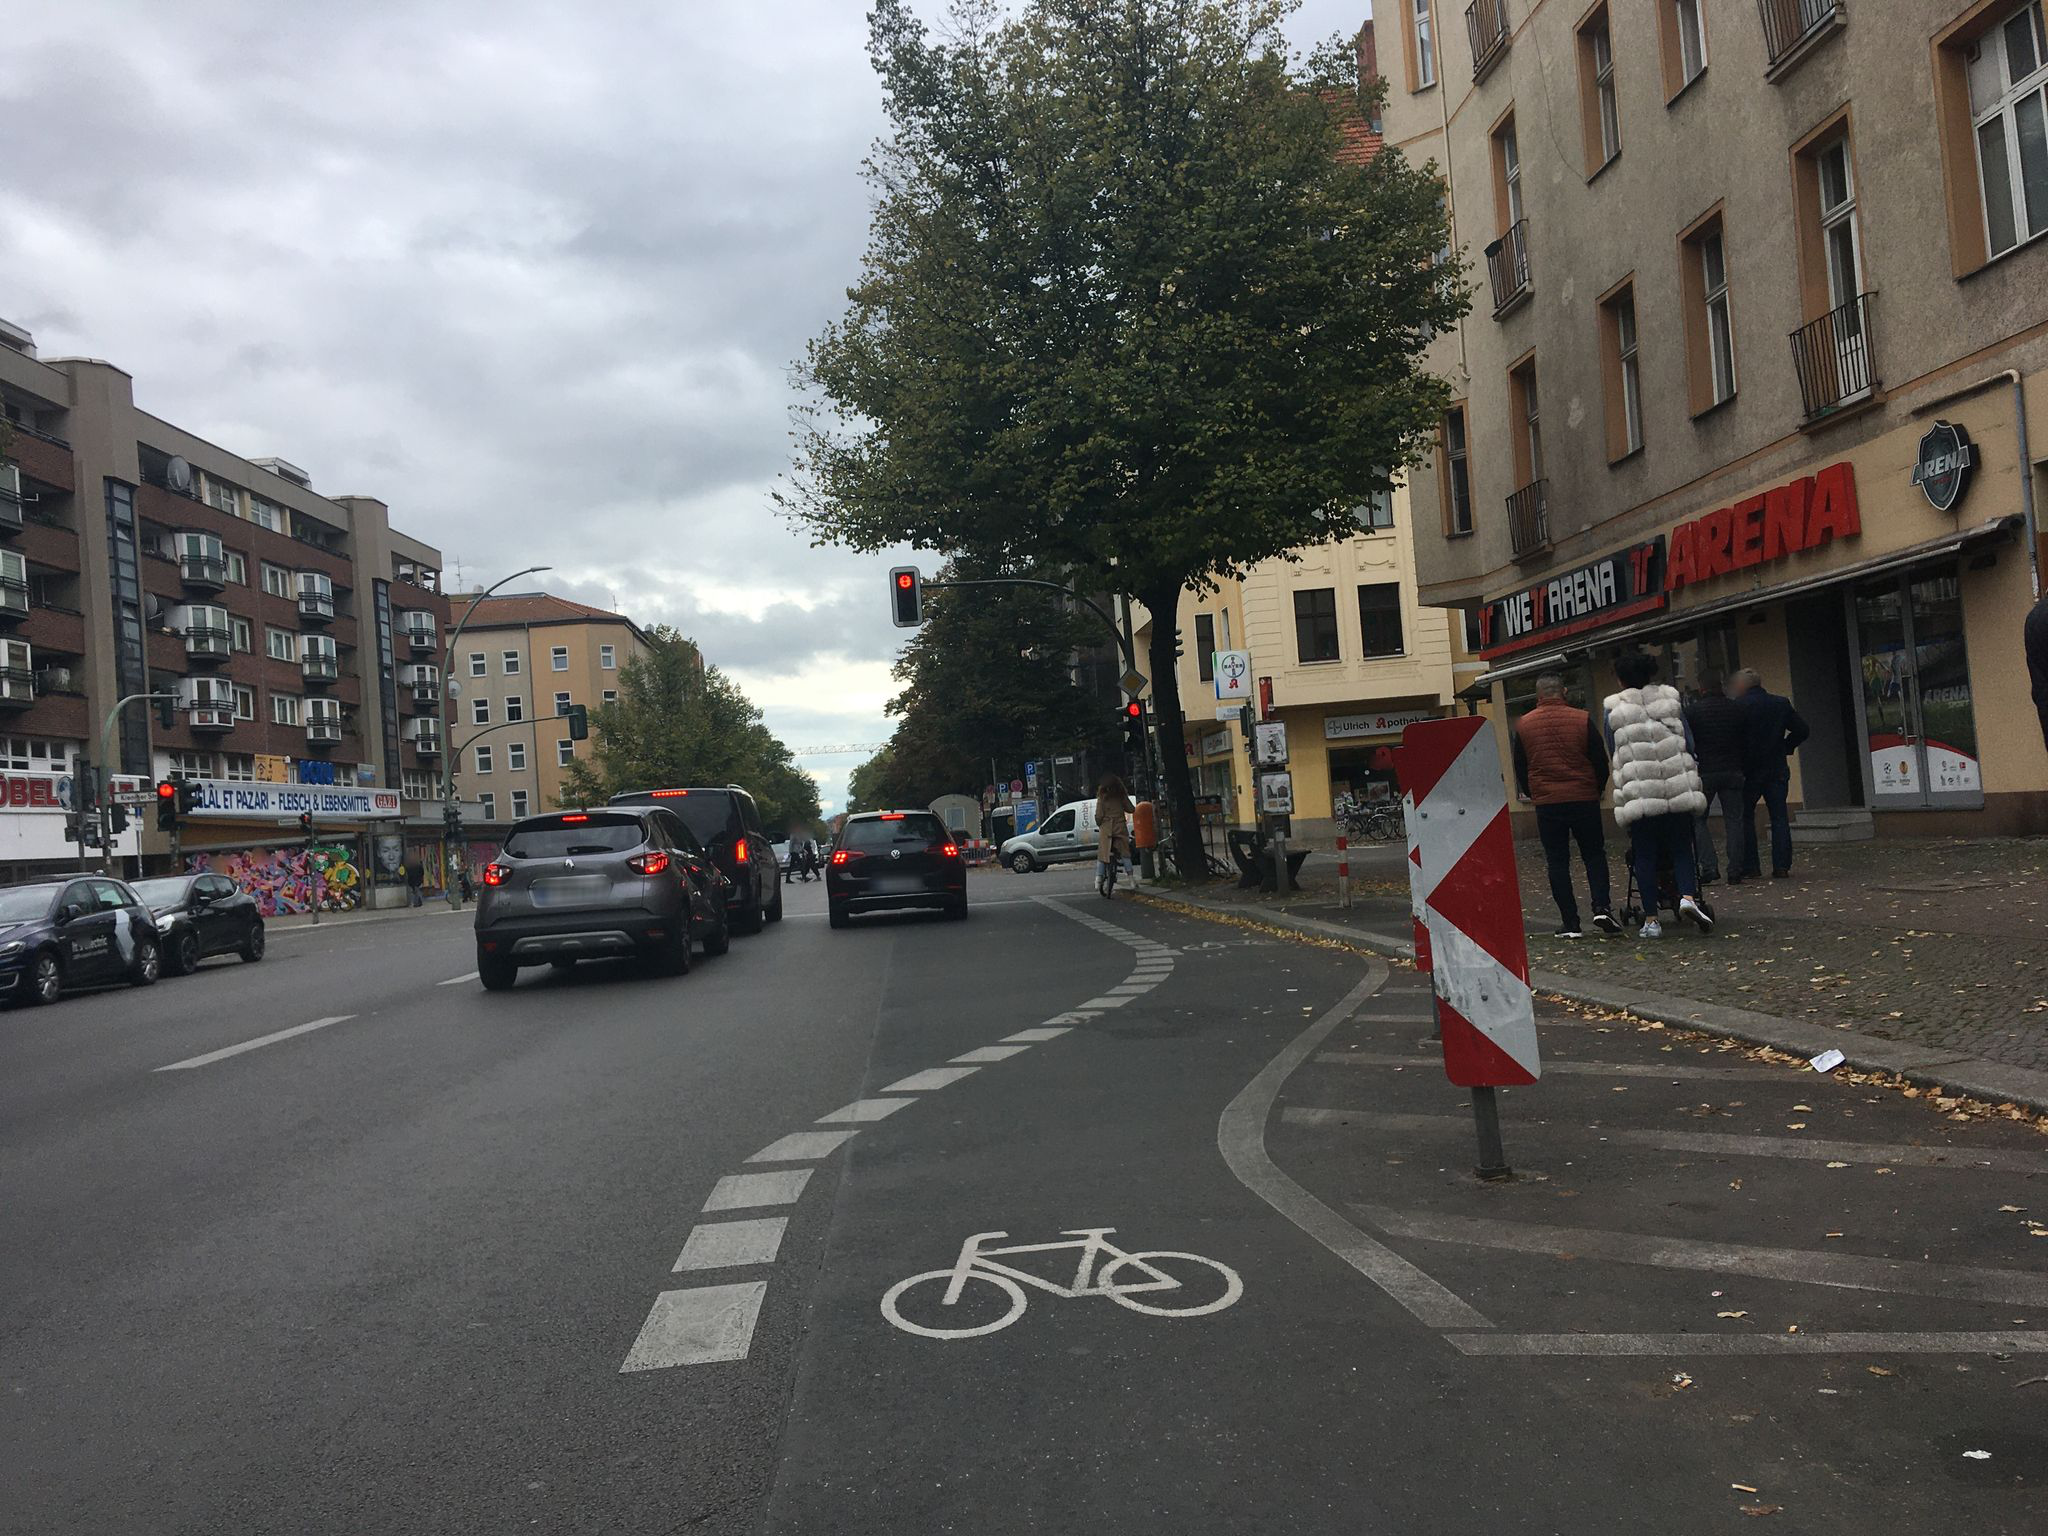

In [24]:
from PIL import Image
import requests

url = 'https://scontent-ber1-1.xx.fbcdn.net/m1/v/t6/An9uzB4ppevzT85qHHTZwEhpOhuz_r87F7l376L6b-eQKrl45EjO5N12Z06UfUEFEnWKOqsKMBNRdkONObe-iuE9yWoRf7IOYEdTuGPkV_qtJmWEq_t5re8u7c-37yFcCqCnOwulFvs3xxSg0u3kCg?stp=s2048x1536&ccb=10-5&oh=00_AfD4sIzpkC-kfX9wXmvk_45VGq4tUMvC153H7EpsV_9fYA&oe=64AFEF1B&_nc_sid=49dc0d'
image = Image.open(requests.get(url, stream=True).raw)
image

We prepare the image for the model using the image processor.

In [25]:
inputs = processor(images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])


## Forward pass

Next, we can forward the `pixel_values` and `pixel_mask` through the model. We use the `torch.no_grad()` context manager as we don't need gradients to be computed (this is only useful when training a model). This will save us a lot of memory.

In [26]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

## Visualize

For visualization, we can postprocess the outputs of the model. In case of panoptic segmentation, the model predicts 2 things per image: 1) a segmentation map 2) a corresponding segments_info (which contains more information regarding the segments in the segmentation map).

In [27]:
# you can pass them to processor for postprocessing
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(predicted_map.shape)

torch.Size([1536, 2048])


We can draw the semantic segmentation map (with one label per pixel) over the image:

In [28]:
# generate random color palette, which maps each class to a RGB value
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
print(color_palette)

[[132, 11, 170], [4, 158, 155], [239, 53, 245], [221, 196, 38], [221, 87, 16], [195, 44, 77], [187, 104, 92], [38, 232, 7], [76, 123, 138], [115, 95, 104], [30, 32, 43], [101, 231, 202], [182, 252, 142], [233, 62, 221], [169, 52, 148], [89, 16, 175], [52, 195, 253], [236, 215, 195], [176, 40, 128], [241, 27, 106], [99, 246, 55], [228, 54, 137], [44, 76, 78], [221, 53, 167], [72, 212, 142], [244, 117, 44], [233, 123, 5], [22, 54, 158], [220, 33, 153], [50, 145, 208], [33, 0, 137], [132, 84, 195], [244, 120, 185], [150, 163, 35], [123, 64, 233], [161, 113, 111], [82, 221, 62], [125, 12, 234], [86, 129, 96], [75, 246, 144], [26, 125, 220], [231, 6, 192], [4, 125, 112], [75, 83, 5], [221, 23, 27], [54, 103, 220], [223, 59, 222], [229, 246, 155], [61, 170, 92], [197, 208, 122], [95, 165, 100], [198, 240, 4], [127, 58, 211], [205, 225, 151], [149, 57, 255], [243, 235, 31], [149, 204, 249], [11, 80, 183], [223, 163, 64], [185, 170, 67], [6, 94, 220], [190, 60, 233], [167, 201, 86], [43, 174, 

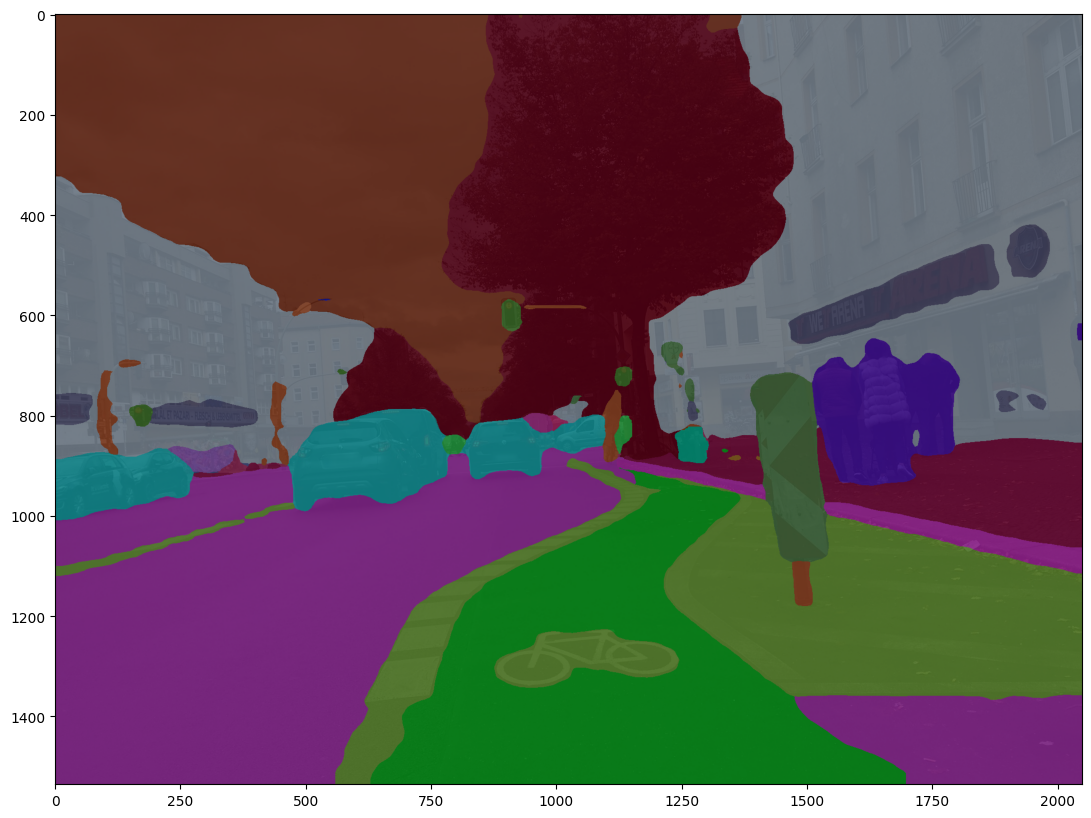

In [30]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()